# Solving photoacoustic least squares with IterativeSolvers.jl 

In this tutorial, we will illustrate how to use Photoacoustic.jl in tandem with the solvers in IterativeSolvers.jl to solve inverse problems. Our illustration will be a photoacoustic inverse problem where the observe data has been generated by a photoacoustic operator plus corrupting noise:
$y = Ax^{\star} + \varepsilon$ where we assume the noise comes from a standard Normal distribution. We want to solve this inverse problem in the least squares sense:
$$\hat x = \mathrm{argmin}_{x} \, \|Ax - y\|_2^2$$

To use the solvers in IterativeSolver.jl all we need is to define matrix vector products $Av$ and adjoint matrix vector products $A^{\top}v$. These are both implemented in PhotoAcoustic.jl.

In [1]:
using PhotoAcoustic
using JUDI
using PyPlot
using LinearAlgebra

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1423


# Define photoacoustic simulation

In [2]:
# Set up model structure
n = (64, 64)   # (x,y,z) or (x,z)
d = (0.08f0, 0.08f0)
o = (0., 0.)

# Constant water velocity [mm/microsec]
v = 1.5*ones(Float32,n) 
m = (1f0 ./ v).^2 # JUDI is parameterized by slowness

# Setup model structure
model = Model(n, d, o, m;)

# Set up receiver geometry (receivers on top of model)
nxrec = 64
xrec = range(0, stop=d[1]*(n[1]-1), length=nxrec)
yrec = [0f0]
zrec = range(0, stop=0, length=nxrec)

# receiver sampling and recording time
time = 5.2333 #[microsec] 
dt = calculate_dt(model) / 2    

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=1)

# Setup operators
opt = Options(dt_comp=dt)
F = judiModeling(model; options=opt)
A = judiPhoto(F, recGeometry;)

JUDI forward{Float32} propagator (z * x) -> (src * rec * time)

As ground truth we use a realistic model of a blood vessel derived from lung ct scans. 

In [3]:
x = judiInitialState(randn(Float32, n...))

judiInitialState{Float32} with 1 sources


# Make observed data 

Operator `forward` ran in 0.11 s


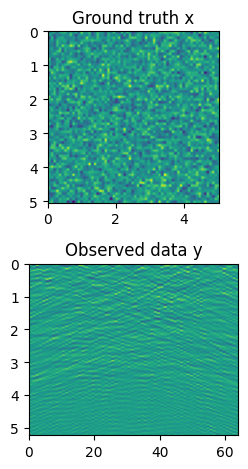

In [13]:
# Run forward model and add noise
y = A*x 
y = y + judiVector(recGeometry, 0.1f0*randn(Float32, size(y.data[1])))

data_extent = (0, nxrec, time,0)
model_extent = (0,(n[1]-1)*d[1],(n[2]-1)*d[2],0)

subplot(2,1,1); title("Ground truth x")
imshow(x.data[1];extent=model_extent )

subplot(2,1,2); title("Observed data y")
imshow(y.data[1];extent=data_extent, aspect=10)

tight_layout()

## Iteratively solve using different algorithms:

In [5]:
using IterativeSolvers

maxiters = 20

x_adj = A'*y
x_lsqr = 0f0 .* x
_, history_lsqr = lsqr!(x_lsqr, A, y; maxiter=maxiters, verbose=true, log=true)

=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	4.90e+00	7.48e-01	1.79e+00	6.51e-01
  2	3.25e+00	4.52e-01	8.06e-01	4.32e-01
  3	2.41e+00	2.56e-01	5.23e-01	3.20e-01
  4	2.05e+00	1.57e-01	3.91e-01	2.73e-01
  5	1.92e+00	9.30e-02	3.10e-01	2.55e-01
  6	1.86e+00	5.77e-02	2.56e-01	2.47e-01
  7	1.83e+00	3.78e-02	2.18e-01	2.43e-01
  8	1.81e+00	2.70e-02	1.88e-01	2.41e-01
  9	1.81e+00	2.17e-02	1.64e-01	2.40e-01
 10	1.80e+00	2.00e-02	1.44e-01	2.39e-01
 11	1.79e+00	1.67e-02	1.28e-01	2.38e-01
 12	1.79e+00	1.32e-02	1.15e-01	2.37e-01
 13	1.78e+00	1.16e-02	1.04e-01	2.37e-01
 14	1.78e+00	9.47e-03	9.57e-02	2.36e-01
 15	1.78e+00	8.70e-03	8.78e-02	2.36e-01
 16	1.78e+00	7.83e-03	8.12e-02	2.36e-01
 17	1.77e+00	7.26e-03	7.53e-02	2.36e-01
 18	1.77e+00	5.99e-03	7.02e-02	2.35e-01
 19	1.77e+00	5.14e-03	6.58e-02	2.35e-01
 20	1.77e+00	4.69e-03	6.19e-02	2.35e-01



Building adjoint operator
Operator `adjoint` ran in 0.12 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.11 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.11 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.11 s
Operator `adjoint` ran in 0.13 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.10 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.11 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.10 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.10 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.12 s
Operator `adjoint` ran in 0.12 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0.10 s
Operator `adjoint` ran in 0.11 s
Operator `Kernel` ran in 0.01 s
Operator `forward` ran in 0

(judiInitialState{Float32} with 1 sources, Converged after 20 iterations.)

### Plotting convergence history

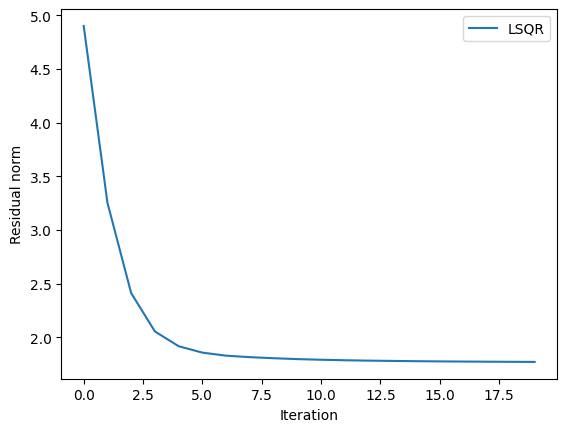

PyObject <matplotlib.legend.Legend object at 0x152130490>

In [6]:
plot(history_lsqr[:resnorm];label="LSQR")
ylabel("Residual norm"); xlabel("Iteration"); legend()

### Plotting results

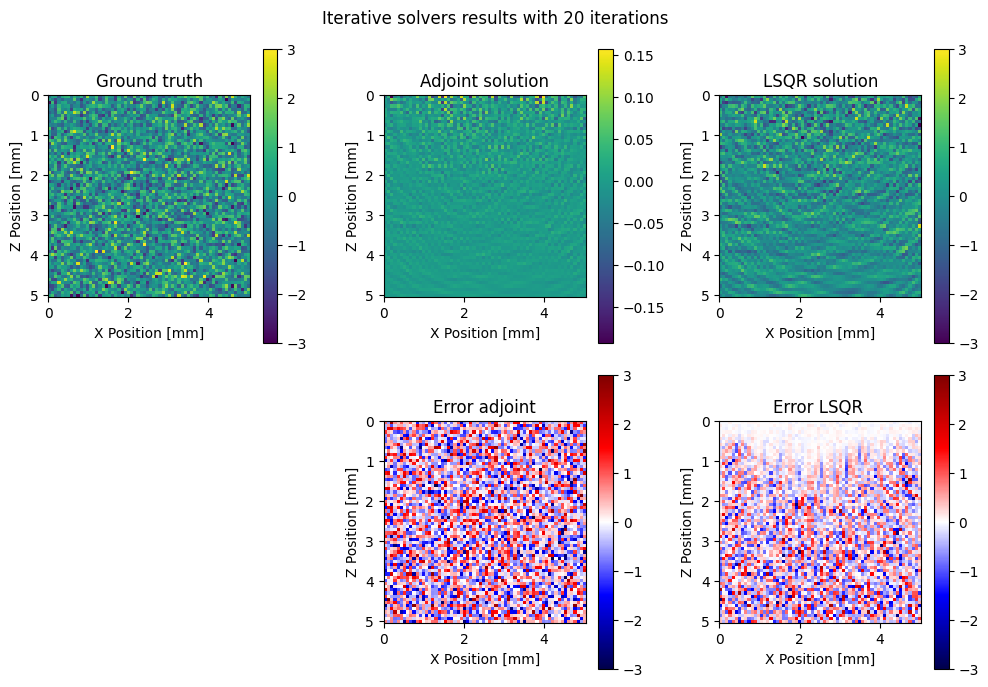

In [14]:
fig = figure(figsize=(10,7))
suptitle("Iterative solvers results with $(maxiters) iterations")
subplot(2,3,1); title("Ground truth") 
imshow(x.data[1];extent=model_extent, vmin=-3,vmax=3)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,2);  title("Adjoint solution")
imshow(x_adj.data[1]';extent=model_extent)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,3); title("LSQR solution")
imshow(x_lsqr.data[1]';extent=model_extent, vmin=-3, vmax=3)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,5);  title("Error adjoint")
imshow(x_adj.data[1]' - x.data[1]';cmap="seismic", extent=model_extent, vmin=-3, vmax=3)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

subplot(2,3,6); title("Error LSQR ")
imshow(x_lsqr.data[1]'- x.data[1]';cmap="seismic",extent=model_extent, vmin=-3, vmax=3)
ylabel("Z Position [mm]";); xlabel("X Position [mm]"; ); colorbar()

tight_layout()